In [ ]:
from combinatorial_gwas.simulation import SimulatedPheno, SNPInfoUnit
from combinatorial_gwas.genotype import load_genetic_file
import tensorflow as tf
import kerastuner as kt
import sys
import os
import shutil
import string
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import LogisticRegression as lgr
import pickle
import tqdm
import numpy as np
from pathlib import Path
import shap


In [ ]:
try:
    if genome_files != None:
        pass
except:
    genome_files = {chromosome: load_genetic_file(chromosome) for chromosome in tqdm.tqdm(list(range(1, 23)), "Loading genotype file(s)")}
def load_datasource(file, nt, dt):
    with open(file, 'rb') as f:
        key = Path(file).stem
        out = pickle.load(f)['datasource']
        out.genome_files = genome_files
        return out

Loading genotype file(s): 100%|██████████| 22/22 [00:56<00:00,  2.59s/it]


In [ ]:
output_datapath = "../../data/07_model_output/dnn/4_29_2021_actual/phenotype_I83_threshold_1e-08_max-samples_300000"
ds = load_datasource(output_datapath,None,None)

In [ ]:
def shap_scores(model,x_train,x_test):
    #Assert correct input shape of x_train
    
    background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
    explainer = shap.LinearExplainer(model,background)
    shap_values = explainer.shap_values(x_test)
    return shap_values

In [ ]:
rt_x, rt_y = ds.get_data(slice(0, None), 'train_tune')
t_x, t_y = ds.get_data(slice(0, None), 'test')

Loading genotype data from split='train_tune':   0%|          | 0/22 [00:00<?, ?it/s]

reading -- time=0:00:00.24, thread 1 of 24, part 5 of 5


reading -- time=0:00:00.37, thread 1 of 24, part 8 of 8



reading -- time=0:00:00.05, thread 1 of 24, part 2 of 2


reading -- time=0:00:00.26, thread 1 of 24, part 7 of 7


reading -- time=0:00:00.19, thread 1 of 24, part 5 of 5



reading -- time=0:00:00.14, thread 1 of 24, part 4 of 4



reading -- time=0:00:00.05, thread 1 of 24, part 2 of 2


reading -- time=0:00:00.05, thread 1 of 24, part 2 of 2



reading -- time=0:00:00.45, thread 1 of 24, part 10 of 10


reading -- time=0:00:00.06, thread 1 of 24, part 3 of 3



reading -- time=0:00:00.00, thread 1 of 2, part 1 of 1


Loading genotype data from split='test':   0%|          | 0/22 [00:00<?, ?it/s]

reading -- time=0:00:00.20, thread 1 of 24, part 5 of 5


reading -- time=0:00:00.36, thread 1 of 24, part 8 of 8



reading -- time=0:00:00.28, thread 1 of 24, part 7 of 7


reading -- time=0:00:00.21, thread 1 of 24, part 5 of 5



reading -- time=0:00:00.15, thread 1 of 24, part 4 of 4



reading -- time=0:00:00.03, thread 1 of 24, part 2 of 2



reading -- time=0:00:00.44, thread 1 of 24, part 10 of 10


reading -- time=0:00:00.10, thread 1 of 24, part 3 of 3



reading -- time=0:00:00.00, thread 1 of 2, part 1 of 1


In [ ]:
rt_x.shape

(60000, 1188, 4)

In [ ]:
def SNP_loop(x_train,x_test,y_train,num_samples):    
    a,b,c = x_train.shape
    output_shap = np.zeros((num_samples,0,c))
    
    for i in range(b):
        x_train1 = np.squeeze(x_train[:num_samples,i,:])
        x_test1 = np.squeeze(x_test[:num_samples,i,:])
        y_train1 = y_train[:num_samples,...]
        model = lgr().fit(x_train1,y_train1)
        scores = shap_scores(model,x_train1[:num_samples,...],x_test1[:num_samples,...])
        scores3 = np.expand_dims(scores,axis=1)
        output_shap = np.append(output_shap,scores3,axis=1)
        
    return [output_shap]

In [ ]:
results = SNP_loop(rt_x,t_x,rt_y,700)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

In [ ]:
results[0].shape

(700, 1188, 4)

In [ ]:
def get_major_indices(shap_scores):
    ys = [np.unique(np.nonzero(score)[1]) for score in shap_scores]
    nonzeros = [score[:, y, :] for y, score in zip(ys, shap_scores)]
    l2s = [y[np.argsort(np.sum(np.sum(nonzero ** 2, axis=2), axis=0))] for y, nonzero in zip(ys, nonzeros)]
    l1s = [y[np.argsort(np.sum(np.sum(np.abs(nonzero), axis=2), axis=0))] for y, nonzero in zip(ys, nonzeros)]
    return ys, nonzeros, l2s, l1s

In [ ]:
get_major_indices(results)

([array([   2,    3,    4,    5,    6,    7,    8,   10,   11,   12,   13,
           14,   15,   16,   17,   19,   20,   21,   22,   23,   24,   25,
           26,   27,   28,   29,   31,   32,   34,   35,   36,   37,   38,
           39,   40,   41,   42,   43,   44,   45,   46,   47,   48,   49,
           50,   53,   54,   55,   56,   57,   58,   59,   60,   62,   63,
           64,   65,   66,  117,  118,  119,  120,  121,  123,  124,  125,
          126,  127,  128,  129,  130,  131,  132,  133,  134,  135,  136,
          138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
          149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
          160,  162,  163,  164,  165,  166,  167,  168,  169,  170,  171,
          172,  173,  174,  175,  176,  177,  178,  179,  180,  181,  182,
          183,  184,  185,  186,  188,  189,  190,  191,  192,  193,  194,
          195,  196,  197,  198,  199,  200,  201,  202,  203,  204,  205,
          206,  207,  208

In [ ]:
rt_x2 = matrix_reshape(rt_x)
t_x2 = matrix_reshape(t_x)
print(rt_x.shape)
print(rt_x2.shape)
print(t_x.shape)
print(t_x2.shape)

(60000, 1188, 4)
(60000, 4752)
(35765, 1188, 4)
(35765, 4752)


In [ ]:
model = lgr().fit(rt_x2,rt_y)
print(model.score(rt_x2,rt_y))
print(model.score(t_x2,t_y))


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


1.0
0.9321403606878232


In [ ]:
scores = shap_scores(model,rt_x2[:700,...],t_x2[:700,...])

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


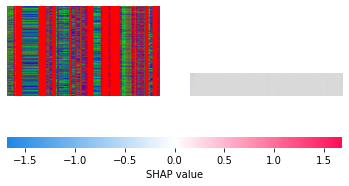

In [ ]:
sorts = shap.image_plot(np.array([scores]),np.array([t_x[:700,...]]))

In [ ]:
#scores3 = matrix_backshape(scores[0],(scores[0].shape[0],scores[0].shape[1]/4,4))
scores3 = scores.reshape(700,rt_x.shape[1],rt_x.shape[2])
x,y,z = np.nonzero(scores3)
y = np.unique(y)
nonzero = scores3[:,y,:]
print(nonzero.shape)


(700, 709, 4)


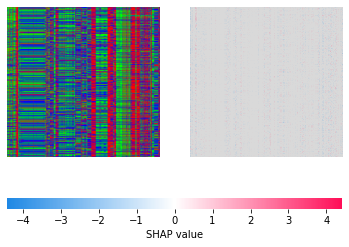

In [ ]:
sorts = shap.image_plot(np.array([nonzero]),np.array([t_x[:700,...][:,y,:]]))

In [ ]:
get_major_indices(scores)
ys,nonzeros,l2s,l1s = get_major_indices(scores)